In [1]:
# general
import numpy as np
import pandas as pd
from scipy.stats import norm

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.naive_bayes import (
    CategoricalNB,
)  # import Naive Bayes Classifier for categorial distributed features
from sklearn.naive_bayes import (
    GaussianNB,
)  # import Naive Bayes Classifier for normal distributed features
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

## Solution 1: Naive Bayes

### a)

In [2]:
# Write dictionary for pandas Data Frame to save Bananas data
dic_bananas = {
    "ID": [1, 2, 3, 4, 5, 6, 7, 8],
    "Color": ["yellow", "yellow", "yellow", "brown", "brown", "green", "green", "red"],
    "Form": [
        "oblong",
        "round",
        "oblong",
        "oblong",
        "round",
        "round",
        "oblong",
        "round",
    ],
    "Origin": [
        "imported",
        "domestic",
        "imported",
        "imported",
        "domestic",
        "imported",
        "domestic",
        "imported",
    ],
    "Bananas": ["yes", "no", "no", "yes", "no", "yes", "no", "no"],
}
data_banana = pd.DataFrame(dic_bananas)
print(data_banana)

   ID   Color    Form    Origin Bananas
0   1  yellow  oblong  imported     yes
1   2  yellow   round  domestic      no
2   3  yellow  oblong  imported      no
3   4   brown  oblong  imported     yes
4   5   brown   round  domestic      no
5   6   green   round  imported     yes
6   7   green  oblong  domestic      no
7   8     red   round  imported      no


In [3]:
# Transform your data with Encoder to get required input

# Initialize Encoder for features
enc_feature = OrdinalEncoder()
enc_target = LabelEncoder()
# Fit encoder
enc_feature.fit(
    data_banana[["Color", "Form", "Origin"]]
)  # Fit encoder on needed feature coulumns
enc_target.fit(data_banana[["Bananas"]].values.ravel())
# .values will give the values in a numpy array (shape: (n,1))
# .ravel will convert that array shape to (n, ) (i.e. flatten it)

# actually transform data and save in old data frame
data_banana[["Color", "Form", "Origin"]] = enc_feature.transform(
    data_banana[["Color", "Form", "Origin"]]
)
data_banana["Bananas"] = enc_target.transform(data_banana["Bananas"].values.ravel())
# you can also use enc_feature.fit_transform(X) to combine both steps

In [4]:
# split the data into features and target
X = data_banana.iloc[:, 1:4].values
y = data_banana.iloc[:, 4].values

# control
print(X)
print(y)
print(enc_feature.categories_)

[[3. 0. 1.]
 [3. 1. 0.]
 [3. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 1. 1.]
 [1. 0. 0.]
 [2. 1. 1.]]
[1 0 0 1 0 1 0 0]
[array(['brown', 'green', 'red', 'yellow'], dtype=object), array(['oblong', 'round'], dtype=object), array(['domestic', 'imported'], dtype=object)]


In [5]:
# Give new observation as Data Frame instead of a List so it does not throw a warning
dic_x_new = {"Color": ["yellow"], "Form": ["round"], "Origin": ["imported"]}
data_x_new = pd.DataFrame(dic_x_new)
x_new = enc_feature.transform(data_x_new)
print(x_new)

[[3. 1. 1.]]


In [6]:
# | label: naivebayes

# initializing the NB
classifer = CategoricalNB(
    alpha=1.0e-10
)  # alpha = 0 for no smoothing towards uniform distribution!! Raises Warning for exactly 0, thus change to very small value

# training the model
classifer.fit(X, y)

# testing the model
y_pred = classifer.predict(x_new)
print("Prediction (0 = no, 1 = yes)", y_pred)
# Prediction is "not Banana"

y_prop = classifer.predict_proba(x_new)
print("Probabilities for (no - yes)", y_prop)

Prediction (0 = no, 1 = yes) [0]
Probabilities for (no - yes) [[0.59016393 0.40983607]]


## Solution 2: Discriminant Analysis

### a) (ii)

We see that the variances in classes 1 and 2 are similar and also much smaller than in class 3. Therefore, the densities could look roughly like this:

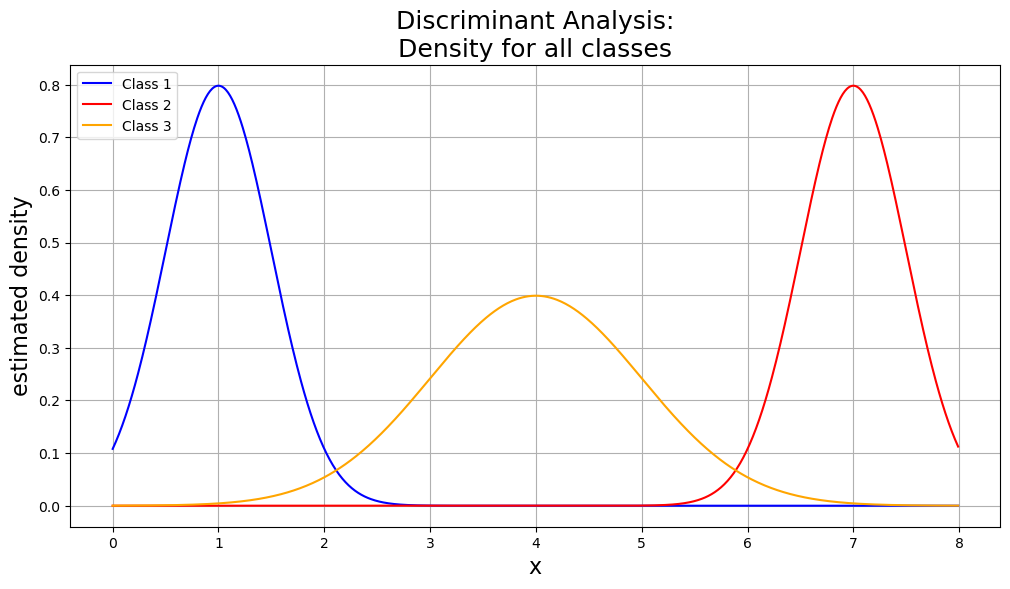

In [7]:
# | label: discriminantanalysis

# Plot differences

# x-axis ranges from -3 and 3 with .001 steps
x = np.arange(0, 8, 0.01)

# plot normal distribution with mean 0 and standard deviation 1
plt.figure(figsize=(12, 6))
plt.plot(x, norm.pdf(x, 1, 0.5), color="blue", label="Class 1")
plt.plot(x, norm.pdf(x, 7, 0.5), color="red", label="Class 2")
plt.plot(x, norm.pdf(x, 4, 1), color="orange", label="Class 3")

# title & label axes
plt.grid(True)
plt.title("Discriminant Analysis:\nDensity for all classes", size=18)
plt.xlabel("x", size=16)
plt.ylabel("estimated density", size=16)
plt.legend(loc="upper left", prop={"size": 10})
plt.show()

##  Exercise 3: Decision Boundaries

You can find the cassini data set in our [GitHub Repo](https://github.com/slds-lmu/lecture_i2ml/blob/master/exercises/data/cassini_data.csv).

In [8]:
# reading the CSV file
cassini = pd.read_csv(
    "https://raw.githubusercontent.com/slds-lmu/lecture_i2ml/master/exercises/data/cassini_data.csv"
)

np.random.seed(43)
cassini["x.2"] = cassini["x.2"] + np.random.normal(loc=0.0, scale=0.5, size=1000)

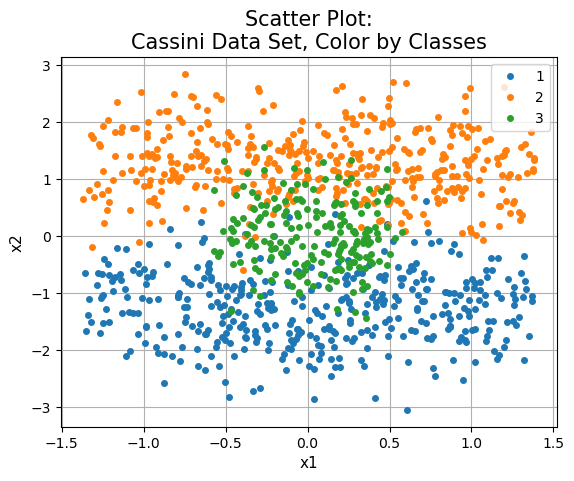

In [9]:
# | label: decb-vis

# Plot data by group
groups = cassini.groupby("classes")
for name, group in groups:
    plt.plot(
        group["x.1"], group["x.2"], marker="o", linestyle="", markersize=4, label=name
    )

plt.legend()
plt.grid(True)
plt.title("Scatter Plot:\nCassini Data Set, Color by Classes", size=15)
plt.xlabel("x1", size=11)
plt.ylabel("x2", size=11)
plt.show()

In [10]:
# | label: decb-learn

# Train all 3 models
X_cass = cassini.iloc[:, 0:2].values
y_cass = cassini.iloc[:, 2].values

# LDA
lda = LDA()
lda.fit(X_cass, y_cass)

# QDA
qda = QDA()
qda.fit(X_cass, y_cass)

# Naive Bayes
# Use Gaussian Naive Bayes
gnb = GaussianNB(var_smoothing=0)  # no smoothing wanted here
gnb.fit(X_cass, y_cass)

GaussianNB(var_smoothing=0)

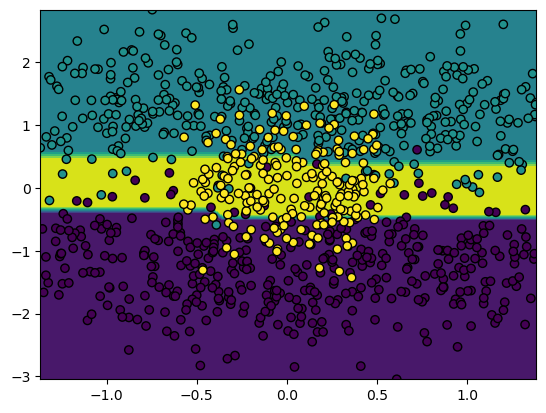

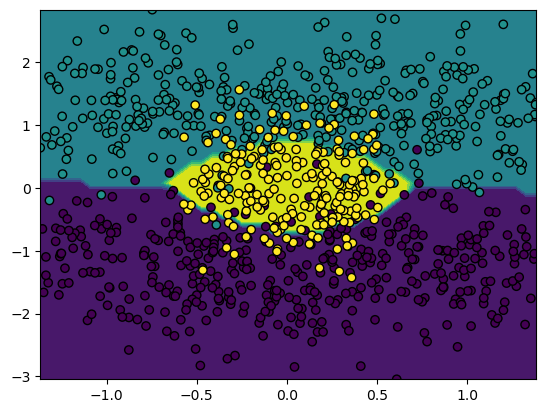

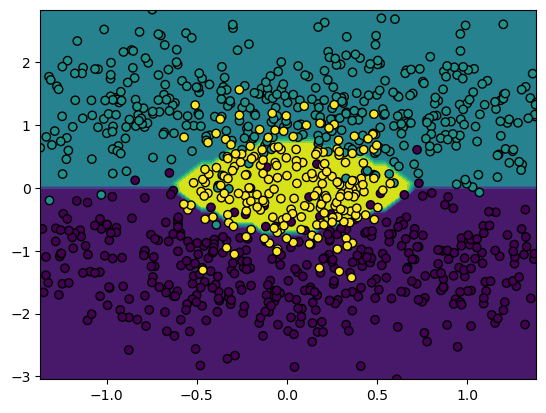

In [11]:
# | label: decb-plot


# Plot Decision Boundaries
def plot_dec_bound(obj):
    """
    Method to produce Decision Boundary Plots
    Input: trained classifier object
    Output: -
    """
    feature_1, feature_2 = np.meshgrid(
        np.linspace(X_cass[:, 0].min(), X_cass[:, 0].max()),
        np.linspace(X_cass[:, 1].min(), X_cass[:, 1].max()),
    )
    grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T

    y_pred = np.reshape(obj.predict(grid), feature_1.shape)
    display = DecisionBoundaryDisplay(xx0=feature_1, xx1=feature_2, response=y_pred)
    display.plot()

    display.ax_.scatter(X_cass[:, 0], X_cass[:, 1], c=y_cass, edgecolor="black")

    plt.show()


class_list = [lda, qda, gnb]

for obj in class_list:
    plot_dec_bound(obj)

We see how LDA, with its confinement to linear decision boundaries, is not able to classify the data very well. QDA and NB, on the other hand, get the shape of the boundaries right. It also becomes obvious that NB is a quadratic classifier just like QDA - their decision surfaces look pretty much alike.

## Extra: Confusion Matrix for Multiclass Classifier

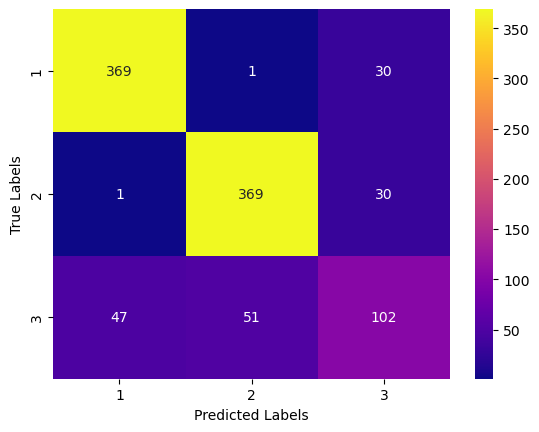

In [12]:
# plot confusion matrix for multiclass
# LDA
sns.heatmap(
    confusion_matrix(y_cass, lda.predict(X_cass)),
    annot=True,
    xticklabels=np.unique(y_cass),
    yticklabels=np.unique(y_cass),
    cmap="plasma",
    fmt="d",
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [13]:
# Print Precision, Recall, and F-Score for Class 1 - 3
precision_recall_fscore_support(y_cass, lda.predict(X_cass))

(array([0.88489209, 0.87648456, 0.62962963]),
 array([0.9225, 0.9225, 0.51  ]),
 array([0.90330477, 0.89890378, 0.56353591]),
 array([400, 400, 200], dtype=int64))